# Confounds in functional MRI
As one of our reviewers noted, most decoding analyses (at least in cognitive neuroscience)
are done on functional MRI, as opposed to structural MRI like we used as our main example in
our paper (i.e., decoding gender from VBM/TBSS data). In this notebook, we simulate relatively
realistic fMRI data (i.e., temporally and spatially autocorrelated data) with and without a 
confound and see how our method (cross-validated confound regression) does and how it compares
to previously proposed methods (like by [Woolgar et al., 2014](https://www.sciencedirect.com/science/article/pii/S1053811914003395).

First, we'll focus on our simulating fMRI data.

## fMRI data simulation
Let's import some packages we need.

In [1]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import pandas as pd

from nistats.hemodynamic_models import spm_hrf
from scipy.ndimage import gaussian_filter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from scipy.stats import pearsonr
from tqdm import tqdm_notebook
from confounds import ConfoundRegressor

%matplotlib inline

Now, we'll create a class, `FmriData`, that is able to generate data by convolving stimulus onsets with an HRF and subsequently estimate the activity estimates of our trials across a range of voxels.

In [2]:
class FmriData:
    """ Generates fMRI data.
     
    Parameters
    ----------
    P : int
        Number of conditions
    I : int
        Number of instances per condition
    I_dur : int
        Duration of trial in seconds (fixed across conditions, P)
    ISIs = list
        List of possible ISIs
    TR : int
        Time to repetition (must be int for simplicity)
    K : tuple
        Voxel dimensions
    ar_rho1 : float
        AR(p) autocorrelation of noise
    smoothness : int
        Spatial smoothing factor (in sigma of voxel dimensions)
    noise_factor : int/float
        How "strong" the noise is (scaling factor for noise covariance matrix V)
    cond_means : list
        List of length P with condition means of activation
    cond_stds : list
        List of length P with condition standard deviation of activation
    confound_corr : float
        Correlation of confound with conditions (assuming 2-class condition for simplicity). If None,
        no confound is simulated.
    """
 
    def __init__(self, P=2, I=20, I_dur=2, ISIs=(4, 5, 6, 7), TR=2, K=(3, 3),
                 ar1_rho=0.5, smoothness=2, noise_factor=1, cond_means=None, cond_stds=None,
                 conf_params=None, single_trial=True):
        """ Initializes FmriData object. """

        self.P = P
        self.I = I
        self.I_dur = I_dur
        self.ISIs = ISIs
        self.TR = TR
        self.K = K
        self.ar1_rho = ar1_rho
        self.smoothness=smoothness
        self.noise_factor = noise_factor
        self.cond_means = cond_means
        self.cond_stds = cond_stds
        self.single_trial = single_trial
        self.conf_params = conf_params

        self.X = None
        self.y = None
        self.conds = None
        self.conf = None
        self.V = None
        self.hrf = None
    
    def generate_data(self, X=None, single_trial=True):
        """ Generates timeseries fMRI data (X, y) with or without confound.
        
        Parameters
        ----------
        X : numpy array or None
            A numpy array of shape (timepoints x P) or (timepoints x (P*I)) for a
            single-trial design ("least-squares all", LSA) or None. When None,
            X is generated.
        single_trial : bool
            When False, the design has a separate regressor for each condition (p = 1 ... P).
            When True, the design has a separate regressor for each trial (i = 1 ... P * I)
            
        Returns
        -------
        X : numpy array
            A numpy array of shape (timepoints x P) or (timepoints x P*I)
        y : numpy array
            A numpy array of shape (timepoints x voxels)
        conds : numpy array
            A numpy array with condition labels (with P unique labels)
        true_betas : numpy array
            A numpy array with the true parameters used to generate the model
        """

        if X is None:  # Generate new X (else: use prespecified X)
            self._generate_X()

        self._generate_y()
        return self.X, self.y, self.conds, self.true_betas
    
    def _generate_conf(self, conds):
        
        weight = 0.0001
        desired_corr = self.conf_params['corr']
        conf = conds * weight + np.random.normal(0, 1, conds.size)
        this_corr = pearsonr(conf, conds)[0]
        while np.abs(this_corr - desired_corr) > 0.01:
            conf = conds * weight + np.random.normal(0, 1, conds.size)
            this_corr = pearsonr(conf, conds)[0]
            weight += 0.0001
    
        conf = (conf - conf.min()) / (conf.max() - conf.min())
        return conf
        
    def _generate_X(self):
        """ Generates X (design matrix). """
        
        single_trial = self.single_trial
        
        # Generate I trials for P conditions
        conds = np.tile(np.arange(self.P), self.I)
        conds = np.random.permutation(conds)  # shuffle trials

        if len(conds) % len(self.ISIs) != 0:
            raise ValueError("Please choose ISIs which can spread across trials evenly.")

        # Generate ISIs and shuffle
        ISIs = np.repeat(self.ISIs, len(conds) / len(self.ISIs))
        ISIs = np.random.permutation(ISIs)
        run_dur = (np.sum(ISIs) + self.I_dur * len(conds))  # run-duration
        
        osf = 10  # oversampling factor for onsets/hrf
        if single_trial:  # nr of regressors = conditions * trials
            X = np.zeros((run_dur * osf, self.P*self.I))
        else:  # nr regressors = nr conditions
            X = np.zeros((run_dur * osf, self.P))

        current_onset = 0  # start creating onsets
        for i, trial in enumerate(conds):

            if single_trial:
                X[current_onset:(current_onset + self.I_dur * osf), i] = 1
            else:
                X[current_onset:(current_onset + self.I_dur * osf), trial] = 1

            this_ITI = self.I_dur * osf + ISIs[i] * osf
            current_onset += this_ITI
    
        # Define HRF
        if self.hrf is None:
            hrf = spm_hrf(tr=self.TR, oversampling=self.TR*osf,
                          time_length=32.0, onset=0.0)
            hrf = hrf / np.max(hrf)  # scale HRF, peak = 1
        else:
            hrf = self.hrf

        # If confound model is 'additive', create a regressor based on confound
        # and add to X to take care of convolution (to be used later when "controlling"
        # for its influence)
        if self.conf_params is not None:
            conf = self._generate_conf(conds)
        else:
            conf = np.zeros(conds.size)
            
        conf_pred = np.zeros(run_dur * osf)
        conf_pred[X.sum(axis=1) != 0] = np.repeat(conf, repeats=osf)
        X = np.c_[X, conf_pred]

        # Convolve regressors with HRF
        X = np.hstack([np.convolve(X[:, i], hrf)[:run_dur*osf, np.newaxis]
                       for i in range(X.shape[1])])
        
        X = X[::self.TR*osf, :]  # downsample
        X = np.c_[np.ones(X.shape[0]), X]  # stack intercept

        self.X = X
        self.conds = conds
        self.conf = conf
        
    def _generate_y(self):
        """ Generate signals (y). """
        
        X, conds, single_trial = self.X, self.conds, self.single_trial
        if self.conf_params is None:
            conf_mean, conf_std = 0, 0
        else:
            conf_mean, conf_std = self.conf_params['mean'], self.conf_params['std']

        N = X.shape[0]  # N = (downsampled) timepoints
    
        # Create ar1 covariance matrix and generate noise
        if self.V is None:
            self.V = self._generate_V(N)

        noise = np.random.multivariate_normal(np.zeros(N), self.V,
                                              size=np.prod(self.K)).T
        # Create condition means/stds
        if single_trial:
            # Extract actual means/stds based on condition
            cond_means = np.array([self.cond_means[i] for i in conds])
            cond_stds = np.array([self.cond_stds[i] for i in conds])
        else:
            cond_means = self.cond_means
            cond_stds = self.cond_stds

        # Add conf effects
        cond_means = np.append(cond_means, conf_mean)
        cond_stds = np.append(cond_stds, conf_std)

        # Add intercept effects
        cond_means = np.append(0, cond_means)
        cond_stds = np.append(1, cond_stds)

        # Create true paramaters
        cov = np.eye(X.shape[1])
        cov *= cond_stds
        
        if single_trial:
            true_betas = np.random.multivariate_normal(cond_means.astype(float),
                                                       cov, size=np.prod(self.K)).T
        else:
            true_betas = np.random.multivariate_normal(cond_means, cov,
                                                       size=np.prod(self.K)).T

        # Create signal!
        y = X.dot(true_betas) + noise
        
        if self.smoothness is not None:  # Smooth if a smoothing kernel has been specified
            #y = gaussian_filter(y.reshape((y.shape[0],) + self.K),
            #                    self.smoothness).reshape((y.shape[0], np.prod(self.K)))
            for i in range(y.shape[0]):
                this_y = y[i, :].reshape(self.K)
                y[i, :] = gaussian_filter(this_y, self.smoothness).ravel()

        self.X = X
        self.y = y
        self.true_betas = true_betas
        
    def fit_glm(self, X=None, y=None, control_for_conf=False, method='LSA', remove_icept=True,
                aggressive=False):
        """ Fits a GLM (using generalized least squares).
        
        Parameters
        ----------
        X : numpy array or None
            If numpy array, X should be a (timepoints x conditions/trials) array.
            If None, the attribute `X` of the object will be used.
        y : numpy array or None
            If numpy array, y should be a (timepoints x voxels) array. If
            None, the attribute `y` of the object will be used.
        control_for_conf : bool
            Whether to control for the confound in the first-level model. Only
            relevant for when confound_mod='additive' was used in data generation.
        remove_icept : bool
            Whether to remove the intercept from the statistics (betas, t-values, etc.)
            that will be returned
        
        Returns
        -------
        est_betas : numpy array
            Array with *estimated* (as opposed to *true*) parameters.
        stderrs : numpy array
            Array with standard errors of the estimated parameters.
        tvals : numpy array
            Array with t-values of the estimated parameters (against baseline)
        """

        if X is None:
            X = self.X
        
        if y is None:
            y = self.y
        
        if control_for_conf:
            if aggressive:  # remove now
                conf = X[:, -1]
                gls_results = sm.GLS(y, X[:, -1, np.newaxis], sigma=self.V).fit()
                y = y - X[:, -1, np.newaxis].dot(gls_results.params)
                X = X[:, :-1]
            else:  # remove later (during model fit)
                X = X
        else:
            X = X[:, :-1]

        est_betas = np.zeros((X.shape[1], y.shape[1]))
        stderrs = np.zeros_like(est_betas)
        tvals = np.zeros_like(est_betas)
        
        for i in range(y.shape[1]):  # loop over voxels
            
            if method == 'LSA':
                gls_results = sm.GLS(y[:, i], X, sigma=self.V).fit()
                est_betas[:, i] = gls_results.params
                stderrs[:, i] = gls_results.bse
                tvals[:, i] = gls_results.tvalues
            elif method == 'LSS':

                if control_for_conf and not aggressive:
                    n_preds = X.shape[1] - 2
                else:
                    n_preds = X.shape[1] - 1

                for ii in range(n_preds):

                    icept = X[:, 0]
                    if control_for_conf and not aggressive:
                        conf = X[:, -1]
                        other_idx = np.ones(X.shape[1]).astype(bool)
                        other_idx[0] = False
                        other_idx[ii + 1] = False
                        other_preds = X[:, other_idx]
                        this_pred = X[:, ii + 1]
                        this_X = np.c_[icept, this_pred, other_preds, conf]
                    else:
                        other_idx = np.ones(X.shape[1]).astype(bool)
                        other_idx[0] = False
                        other_idx[ii + 1] = False
                        other_preds = X[:, other_idx].sum(axis=1)
                        this_pred = X[:, ii + 1]
                        this_X = np.c_[icept, this_pred, other_preds]
                        
                    gls_results = sm.GLS(y[:, i], this_X, sigma=self.V).fit()
                    est_betas[ii+1, i] = gls_results.params[1]
                    stderrs[ii+1, i] = gls_results.bse[1]
                    tvals[ii+1, i] = gls_results.tvalues[1]

            else:
                raise ValueError("Choose either LSA or LSS")

        if control_for_conf and not aggressive:  # remove confound from estimated parameters
            est_betas = est_betas[:-1, :]
            stderrs = stderrs[:-1, :]
            tvals = tvals[:-1, :]

        if remove_icept:  # remove intercept from estimated parameters
            est_betas = est_betas[1:, :]
            stderrs = stderrs[1:, :]
            tvals = tvals[1:, :]
        
        return est_betas, stderrs, tvals

    def _generate_V(self, N):
        """ Generates a autocovariance matrix based on a AR(p) model. """
        rho = self.ar1_rho
        cov = rho ** scipy.linalg.toeplitz(np.arange(N))
        return cov * self.noise_factor

    def plot(self, X, y, conds, voxel=(0, 0)):
        """ Plots the design and signal of a particular voxel from a particular run. """
        fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5), sharex=True)
        
        ax[0].set_prop_cycle('color', [plt.cm.Dark2(i) for i in conds])
        ax[0].plot(X[:, 1:])
        ax[0].axhline(0, ls='--', c='k', lw=1)
        ax[0].set_xlim(0, X.shape[0])
        ax[0].set_xlabel('Time (in dynamics)', fontsize=15)
        ax[0].set_ylabel('Amplitude (a.u.)', fontsize=15)

        yresh = y.reshape((y.shape[0],) + self.K)
        ax[1].plot(yresh[:, voxel[0], voxel[1]])
        ax[1].axhline(0, ls='--', c='k', lw=1)
        ax[1].set_xlabel('Time (in dynamics)', fontsize=15)
        
        sns.despine()
        fig.tight_layout()
        fig.show()


def stack_runs(generator, R=10, control_for_conf=False, aggressive=False, smooth=None):

    all_betas, all_stderrs, all_tvals, all_conf = [], [], [], []
    for i in range(R):
        X, y, conds, true_params = generator.generate_data()
        
        if smooth is not None:
            y = np.hstack([gaussian_filter(y[:, i], sigma=smooth)[:, np.newaxis]
                           for i in range(y.shape[1])])
        
        betas, stderrs, tvals = fmri_gen.fit_glm(X, y, control_for_conf=control_for_conf,
                                                 aggressive=aggressive)
        all_betas.append(betas)
        all_stderrs.append(stderrs)
        all_tvals.append(tvals)
        all_conf.append([np.mean(generator.conf[conds == i]) for i in range(generator.P)])
        
    betas = np.vstack(all_betas)
    stderrs = np.vstack(all_stderrs)
    tvals = np.vstack(all_tvals)
    conf = np.concatenate(all_conf)
    
    if generator.single_trial:
        target = np.tile(conds, R)
        group = np.repeat(conds, R)
    else:
        target = np.tile(np.arange(generator.P), R)
        group = np.repeat(np.arange(generator.P), R)

    return betas, stderrs, tvals, target, group, conf

So, how does this work? Well, for our purposes, we'll generate the signal(s), $y$, as function of the design, $X$, the true parameters, $\beta$, and noise, $\epsilon$, in the following manner:

\begin{align}
y = X\beta + \epsilon
\end{align}

Here, we generate $\epsilon$ from a multivariate normal distribution with mean $\mu = 0$ and covariance matrix $V$:

\begin{align}
\epsilon \sim N(0, V)
\end{align}

V is assumed to follow an AR(p) model.

Then, we generate $\beta$ from a $K$-dimensional (number of voxels) multivariate normal distribution with means $\mu$ and covariance matrix $\sigma I$, where $I$ is the identity matrix (i.e., the true parameters $\beta$ are uncorrelated across voxels, but may differ in variance):

\begin{align}
\beta \sim N(\mu, \sigma I)
\end{align}

Lastly, $X$ is constructed as a set of regressors (one for each trial) that are the result of a convolution of a finite impulse response and an HRF:

\begin{align}
X_{j} = conv(X_{j}, HRF) 
\end{align}

## Generating null-data
Alright, so let's specify some parameters for our experiment. We'll make sure it represents null-data (no effect; i.e., no reliable difference between voxels patterns across $P$ conditions) by setting the condition-means to `(1, 1)`.

Alright, now let's check whether it's really null data. We'll simulate data 100 times and check the average decoding accuracy:

In [177]:
default_pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=True)

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
    mean_acc[i] = cross_val_score(default_pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Let's also try it for run-wise decoding:

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=False)

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    _, _, tvals, target, group, conf = stack_runs(fmri_gen, R=10)
    mean_acc[i] = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Alright, that checks out! Now, just to be sure, let's simulate data with some effect (i.e., difference in patterns between conditions). We'll set the condition means to 1.0 and 1.1. This should increase our decoding accuracy.

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1.1),
                    cond_stds=(0.5, 0.5), single_trial=True)

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
    mean_acc[i] = cross_val_score(default_pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

And run-wise decoding:

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1.1),
                    cond_stds=(0.5, 0.5), single_trial=True)

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):
    
    _, _, tvals, target, group = stack_runs(fmri_gen, R=10)
    mean_acc[i] = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

This makes sense! Now, let's check out what happens when we include a confound.

## Generating data with a confound
Now, we'll simulate some data affected by a confound. To generate the data, we'll use the "additive" model from the Woolgar et al. article. In this model, they assume the confound has some additive effect on the true activation parameters of each voxel. Accordingly, we generate the data as:

\begin{align}
y = X\beta_{X} + C\beta_{C} + \epsilon
\end{align}

where $C$ is an array of shape ($N \times 1$) representing the confound onsets convolved with an HRF. In our data generation, $C$ can be generated with a prespecified correlation to the conditions and the weight ($\beta_{C}$) is drawn from a normal distribution:

\begin{align}
\beta_{C} \sim N(\mu_{\beta_{C}}, \sigma_{\beta_{C}})
\end{align}

Think of $C$ like something as reaction time that may have an additional effect on voxels that (may or may not) encode something like rules (like in the original Woolgar article). Now, we'll set the condition means to zero again to simulate some null-data, but we're also setting the correlation between the confound and the true conditions to 0.5, so we expect based on the confound alone that the decoding accuracy will be higher.

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=True,
                    conf_params=dict(corr=0.5, mean=1, std=0))

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y)
    mean_acc[i] = cross_val_score(default_pipe, tvals, conds, cv=10).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Again, let's try it for run-wise decoding:

In [ ]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=False,
                    conf_params=dict(corr=0.5, mean=1, std=0))

iters = 10
mean_acc = np.zeros(iters)
for i in tqdm_notebook(range(iters)):

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderss, tvals = fmri_gen.fit_glm(X, y)
    _, _, tvals, target, group, conf = stack_runs(fmri_gen, R=10)
    mean_acc[i] = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()

plt.hist(mean_acc)
plt.axvline(mean_acc.mean(), c='r', ls='--')
plt.show()

print("Mean accuracy across iterations: %.3f" % mean_acc.mean())

Alright, that seems to work! Interestingly, the run-wise decoding accuracy is affected more, but probably because it more or less has 10 times the power (10 x 80 trials instead of 80 trials in one run). Now, how to control for this influence? We can of course use confound regression! Let's actually test both WDCR and CVCV. We expect, given the result from the main paper, that WDCR will yield negative bias while CVCR will yield relatively unbiased results.

### WDCR
WDCR entails regressing our the confound ($C$) from the data ($X$) before cross-validation (i.e, $X = X - C\beta$) on a range of correlations between the target and the confound. First, let's do it with trial-wise decoding:

In [ ]:
results = dict(acc=[], method=[], corr=[])
for corr in tqdm_notebook(np.arange(0, 1.05, 0.1)):

    iters = 10
    for ii in range(iters):
        fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                        K=(10, 10), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=True,
                        conf_params=dict(corr=corr, mean=1, std=0))

        X, y, conds, true_params = fmri_gen.generate_data()
        betas, stders, tvals = fmri_gen.fit_glm(X, y)
        acc = cross_val_score(default_pipe, tvals, conds, cv=10).mean()
        results['acc'].append(acc)
        results['method'].append('No control')
        results['corr'].append(corr)

        cfr = ConfoundRegressor(X=tvals, confound=fmri_gen.conf)
        tvals = cfr.fit_transform(tvals)
        acc = cross_val_score(default_pipe, tvals, conds, cv=10).mean()
        results['acc'].append(acc)
        results['method'].append('WDCR')
        results['corr'].append(corr)

df_WDCR_tw = pd.DataFrame(results)
df_WDCR_tw['corr'] = df_WDCR_tw['corr'].round(1)

Let's plot it:

In [ ]:
plt.figure(figsize=(11, 4))
ax = sns.pointplot(data=df_WDCR_tw, x='corr', y='acc', hue='method')
ax.axhline(0.5, ls='--', c='k')
ax.legend(frameon=False, fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$r_{Cy}$', fontsize=20)

sns.despine()
plt.show()

Alright, below-chance accuracy as expected. Does this also happen for run-wise decoding?

In [ ]:
results = dict(acc=[], method=[], corr=[])
for corr in tqdm_notebook(np.arange(0, 1.05, 0.1)):

    iters = 10
    for ii in range(iters):
        fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                        K=(10, 10), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=False,
                        conf_params=dict(corr=corr, mean=1, std=0))

        _, _, tvals, target, group, conf = stack_runs(fmri_gen, R=10)
        acc = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()
        results['acc'].append(acc)
        results['method'].append('No control')
        results['corr'].append(corr)

        cfr = ConfoundRegressor(X=tvals, confound=conf)
        tvals = cfr.fit_transform(tvals)
        acc = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()
        results['acc'].append(acc)
        results['method'].append('WDCR')
        results['corr'].append(corr)

df_WDCR_rw = pd.DataFrame(results)
df_WDCR_rw['corr'] = df_WDCR_rw['corr'].round(1)

Let's plot it:

In [ ]:
plt.figure(figsize=(11, 4))
ax = sns.pointplot(data=df_WDCR_rw, x='corr', y='acc', hue='method')
ax.axhline(0.5, ls='--', c='k')
ax.legend(frameon=False, fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$r_{Cy}$', fontsize=20)

sns.despine()
plt.show()

## CVCR
Let's see how CVCR does. First, trial-wise:

In [ ]:
results = dict(acc=[], method=[], corr=[])
for corr in tqdm_notebook(np.arange(0, 1.05, 0.1)):

    iters = 10
    for ii in range(iters):
        fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                        K=(10, 10), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=True,
                        conf_params=dict(corr=corr, mean=1, std=0))

        X, y, conds, true_params = fmri_gen.generate_data()
        betas, stders, tvals = fmri_gen.fit_glm(X, y)
        acc = cross_val_score(default_pipe, tvals, conds, cv=10).mean()
        
        results['acc'].append(acc)
        results['method'].append('No control')
        results['corr'].append(corr)

        cfr = ConfoundRegressor(X=tvals, confound=fmri_gen.conf)
        cfr_pipe = make_pipeline(cfr, StandardScaler(), SVC(kernel='linear'))
        acc = cross_val_score(cfr_pipe, tvals, conds, cv=10).mean()
        results['acc'].append(acc)
        results['method'].append('CVCR')
        results['corr'].append(corr)

df_CVCR_tw = pd.DataFrame(results)
df_CVCR_tw['corr'] = df_WDCR_tw['corr'].round(1)

And let's plot it:

In [ ]:
plt.figure(figsize=(11, 4))
ax = sns.pointplot(data=df_CVCR_tw, x='corr', y='acc', hue='method')
ax.axhline(0.5, ls='--', c='k')
ax.legend(frameon=False, fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$r_{Cy}$', fontsize=20)

sns.despine()
plt.show()

Now, run-wise:

In [ ]:
results = dict(acc=[], method=[], corr=[])
for corr in tqdm_notebook(np.arange(0, 1.05, 0.1)):

    iters = 10
    for ii in range(iters):
        fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                        K=(10, 10), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=False,
                        conf_params=dict(corr=corr, mean=1, std=0))

        _, _, tvals, target, group, conf = stack_runs(fmri_gen, R=10)
        acc = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()
        results['acc'].append(acc)
        results['method'].append('No control')
        results['corr'].append(corr)

        cfr_pipe = make_pipeline(ConfoundRegressor(X=tvals, confound=conf),
                                 StandardScaler(), SVC(kernel='linear'))
        acc = cross_val_score(cfr_pipe, tvals, target, cv=10, groups=group).mean()
        results['acc'].append(acc)
        results['method'].append('CVCR')
        results['corr'].append(corr)
        
df_CVCR_rw = pd.DataFrame(results)
df_CVCR_rw['corr'] = df_CVCR_rw['corr'].round(1)

And let's plot it:

In [ ]:
plt.figure(figsize=(11, 4))
ax = sns.pointplot(data=df_CVCR_rw, x='corr', y='acc', hue='method')
ax.axhline(0.5, ls='--', c='k')
ax.legend(frameon=False, fontsize=15)
ax.set_ylabel('Accuracy', fontsize=15)
ax.set_xlabel('$r_{Cy}$', fontsize=20)

sns.despine()
plt.show()

That looks good! Now let's plot everything in one figure for the supplementary materials:

In [ ]:
fig, ax = plt.subplots(nrows=2, ncols=2, sharex=True, sharey=True, figsize=(15, 5))
dfs = [df_WDCR_tw, df_WDCR_rw, df_CVCR_tw, df_CVCR_rw]
txts = ['WDCR', 'WDCR', 'CVCR', 'CVCR']

for i, ax in enumerate(ax.flatten()):
    ax = sns.pointplot(data=dfs[i], x='corr', y='acc', hue='method', ax=ax)
    ax.axhline(0.5, ls='--', c='k')
    ax.text(0, 0.1, txts[i], fontsize=20)

    if i > 1:
        ax.legend_.remove()
    else:
        ax.legend(frameon=False)

    if i in [0, 2]:
        ax.set_ylabel('Accuracy', fontsize=15)
    else:
        ax.set_ylabel('')
    
    if i in [2, 3]:
        ax.set_xlabel(r'$r_{Cy}$', fontsize=20)
    else:
        ax.set_xlabel('')

    if i == 0:
        ax.set_title('Trial-wise decoding', fontsize=20)

    if i == 1:
        ax.set_title('Run-wise decoding', fontsize=20)
        
fig.tight_layout()
sns.despine()


## Autocorrelated patterns

One reviewer was interested in how CVCR would behave when patterns would be more or less autocorrelated. Let's check that out! We can vary autocorrelation in our data generation process easily by varying the ISIs between trials: shorter ISIs will yield more autocorrelation between patterns. Let's verify this by plotting the correlation matrix between patterns for various ISIs. We expect to see "brighter" values around the diagonal for short ISIs.

In [ ]:
smoothing_kernels = [0, 1, 2, 3, 4]
plt.figure(figsize=(15, 5))
for i, sk in enumerate(smoothing_kernels):

    fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=True,
                    conf_params=dict(corr=0.5, mean=1, std=0))

    X, y, conds, true_params = fmri_gen.generate_data()
    y = np.hstack([gaussian_filter(y[:, i], sigma=sk)[:, np.newaxis]
                   for i in range(y.shape[1])])
    betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True)
    
    pattern_corrs = np.corrcoef(tvals)
    plt.subplot(1, len(smoothing_kernels), i+1)
    # Note the scaling: this emphasizes the contrast between high and 
    # low correlations
    plt.imshow(pattern_corrs)
    plt.axis('off')
    plt.title("Smoothing kernel: %i" % sk, fontsize=15)
    
plt.tight_layout()
plt.show()

You can clearly see that the patterns are more autocorrelated for short ISIs. (Note that for lower ISIs, the first-level model becomes non-invertible.)

Now, how does CVCR do with these different types of data?

In [182]:
smooth_kernel = [0, 1, 2, 3, 4]
results = dict(acc=[], kernel=[], method=[], corr=[], analysis=[])

for i, sk in tqdm_notebook(enumerate(smooth_kernel)):
    
    for corr in tqdm_notebook(np.arange(0, 1.05, 0.1)):
        
        iters = 100
        for ii in range(iters):
            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                            K=(4, 4), ar1_rho=0.5, smoothness=1,
                            noise_factor=1, cond_means=(0, 0),
                            cond_stds=(0.5, 0.5), single_trial=True,
                            conf_params=dict(corr=corr, mean=1, std=0))

            X, y, conds, true_params = fmri_gen.generate_data()
            y = np.hstack([gaussian_filter(y[:, i], sigma=sk)[:, np.newaxis]
                           for i in range(y.shape[1])])
    
            betas, stders, tvals = fmri_gen.fit_glm(X, y)
            acc = cross_val_score(default_pipe, tvals, conds, cv=10).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('No control')
            results['corr'].append(corr)
            results['analysis'].append('Trial-wise')

            cfr_pipe = make_pipeline(ConfoundRegressor(X=tvals, confound=fmri_gen.conf),
                                     StandardScaler(), SVC(kernel='linear'))

            acc = cross_val_score(cfr_pipe, tvals, conds, cv=10).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('CVCR')
            results['corr'].append(corr)
            results['analysis'].append('Trial-wise')
            
            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                                K=(4, 4), ar1_rho=0.5, smoothness=1,
                                noise_factor=1, cond_means=(0, 0),
                                cond_stds=(0.5, 0.5), single_trial=True,
                                conf_params=None)

            X, y, conds, true_params = fmri_gen.generate_data()
            y = np.hstack([gaussian_filter(y[:, i], sigma=sk)[:, np.newaxis]
                           for i in range(y.shape[1])])
    
            betas, stders, tvals = fmri_gen.fit_glm(X, y)
            acc = cross_val_score(default_pipe, tvals, conds, cv=10).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('Baseline')
            results['corr'].append(corr)
            results['analysis'].append('Trial-wise')
            ###################
            
            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                            K=(4, 4), ar1_rho=0.5, smoothness=1,
                            noise_factor=1, cond_means=(0, 0),
                            cond_stds=(0.5, 0.5), single_trial=False,
                            conf_params=dict(corr=corr, mean=1, std=0))

            _, _, tvals, target, group, conf = stack_runs(fmri_gen, smooth=sk)
            acc = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('No control')
            results['corr'].append(corr)
            results['analysis'].append('Run-wise')

            cfr_pipe = make_pipeline(ConfoundRegressor(X=tvals, confound=conf),
                                     StandardScaler(), SVC(kernel='linear'))

            acc = cross_val_score(cfr_pipe, tvals, target, cv=10, groups=group).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('CVCR')
            results['corr'].append(corr)
            results['analysis'].append('Run-wise')
            
            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                                K=(4, 4), ar1_rho=0.5, smoothness=1,
                                noise_factor=1, cond_means=(0, 0),
                                cond_stds=(0.5, 0.5), single_trial=False,
                                conf_params=None)

            _, _, tvals, target, group, conf = stack_runs(fmri_gen, smooth=sk)
            acc = cross_val_score(default_pipe, tvals, target, cv=10, groups=group).mean()
            results['kernel'].append(sk)
            results['acc'].append(acc)
            results['method'].append('Baseline')
            results['corr'].append(corr)
            results['analysis'].append('Run-wise')
            
df_CVCR_sm = pd.DataFrame(results)
df_CVCR_sm['corr'] = df_CVCR_sm['corr'].round(1)

HBox(children=(IntProgress(value=1, bar_style='info', max=1), HTML(value='')))

HBox(children=(IntProgress(value=0, max=11), HTML(value='')))

KeyboardInterrupt: 

Plot the results:

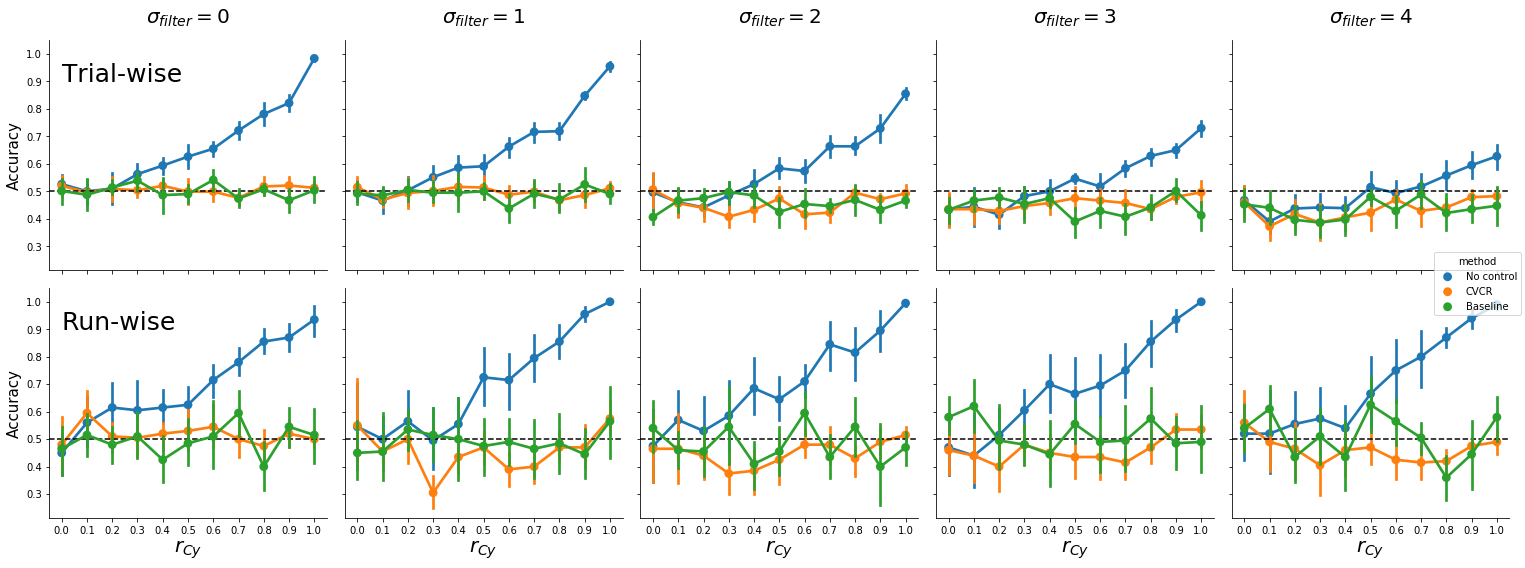

In [181]:
plt.figure(figsize=(11, 4))
g = sns.factorplot(data=df_CVCR_sm, x='corr', y='acc', hue='method', col='kernel', row='analysis')
for i, ax in enumerate(g.axes.flatten()):
    ax.axhline(0.5, ls='--', c='k')
    
    if i == 0:
        ax.text(0, 0.9, 'Trial-wise', fontsize=25)
        
    if i == 5:
        ax.text(0, 0.9, 'Run-wise', fontsize=25)

    if i < 5:
        ax.set_title(r'$\sigma_{filter} = %i$' % np.tile(smooth_kernel, 2)[i], 
                     fontsize=20, y=1.05)
    else:
        ax.set_title('')
    
    if i in [0, 5]:
        ax.set_ylabel('Accuracy', fontsize=15)
    
    if i > 4:
        ax.set_xlabel('$r_{Cy}$', fontsize=20)

plt.tight_layout()

Great, this seems to work!

## Control for confounds during pattern estimation
Alternatively, we can use the method advocated in the Woolgar article. Essentially, the Woolgar article suggests to "remove" the variance associated with the confound in the first-level pattern estimation step (in the article, we can this approach "controlling for confounds during pattern estimation"). Importantly, in the original article, Woolgar and colleagues do not estimate single-trial activity patterns (the LSA-approach), but do "run-wise" decoding on condition-average responses. This actually matters a lot, as we will see later. Now, however, we're going to investigate whether the "control for confounds during pattern estimation" works for LSA-type of pattern estimation (which is quite common in fMRI decoding analyses).

Now, technically, there are two ways to go about this:

1. Add the (HRF-convolved) confound regressor ($C$) to the single-trial regressors ($X$), and then fit the complete design-matrix (with $X$ and $C$ concatenated) to the signal ($y$)
2. Regress out the (HRF-convolved) confound regress from the signal ($y$) *before* fitting the design-matrix (only $X$, no $C$) to the signal ($y$)

How does that work? Well, let's plot the single-trial regressors and the confound-regressor side by side:

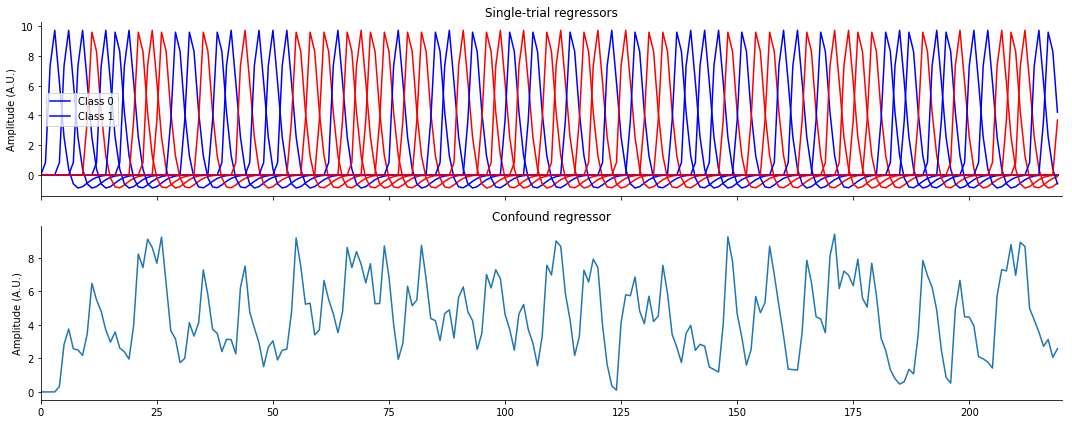

In [54]:
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(2, 1), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=True,
                    conf_params=dict(corr=0.9, mean=2, std=0))

X, y, conds, true_params = fmri_gen.generate_data()
betas, stderrs, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True, aggressive=True)

fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 6))
for i in np.arange(1, 81):
    ax[0].plot(X[:, i], c='r' if conds[i-1] else 'b')

ax[0].legend(['Class 0', 'Class 1'])
ax[0].set_title("Single-trial regressors")

ax[1].plot(X[:, -1])
ax[1].set_title("Confound regressor")

for i in [0, 1]:
    ax[i].set_ylabel('Amplitude (A.U.)')
    ax[i].set_xlim(0, 220)

sns.despine()
plt.tight_layout()

Importantly, the signal ($y$) is generated based on these same regressors (both the single-trial regressors and the confound) with the generative parameters $\beta_{X|y=0} = 1$, $\beta_{X|y=1} = 1$, $\beta_{C} = 2$: they all activate the voxel (signal) equally. Let's actually plot this. You can see by eye that trials of class/condition 1 seem to activate the voxel more than class 0, but this is completely due to the confound. In fact, if we don't control for the confound, this is exactly what is found in the first-level model:

Mean beta, y = 0: 1.566
Mean beta, y = 1: 2.670


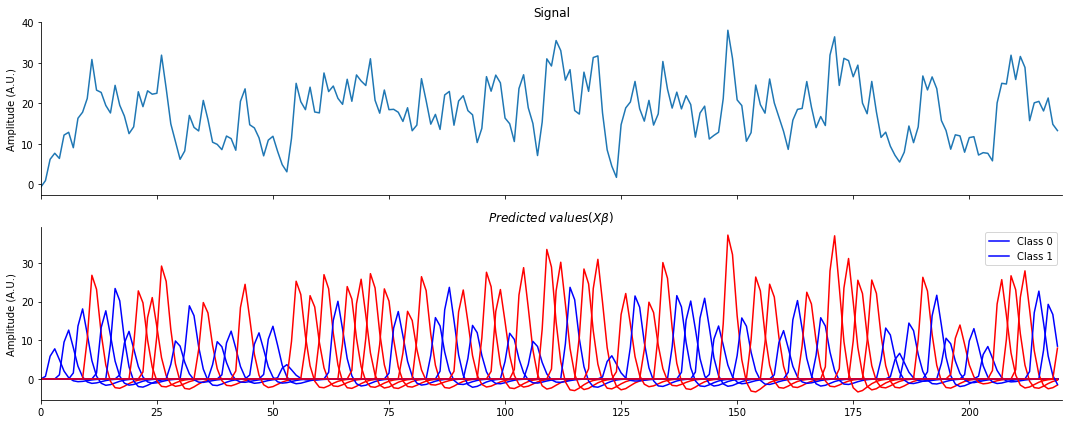

In [55]:
fig, ax = plt.subplots(nrows=2, sharex=True, figsize=(15, 6))
ax[0].plot(y[:, 0])
ax[0].set_title("Signal")

betas, stderrs, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
print("Mean beta, y = 0: %.3f" % betas[conds == 0, 0].mean())
print("Mean beta, y = 1: %.3f" % betas[conds == 1, 0].mean())

for i in np.arange(1, 81):
    ax[1].plot(X[:, i] * betas[i - 1, 0], c='r' if conds[i-1] else 'b')
    
ax[1].set_title(r"$Predicted\ values (X\beta)$")
ax[1].legend(['Class 0', 'Class 1'])

for i in [0, 1]:
    ax[i].set_ylabel('Amplitude (A.U.)')
    ax[i].set_xlim(0, 220)

sns.despine()
plt.tight_layout()

As we can see, the activation parameter estimated for class 1 ($\beta_{X|y=1}$) is overestimated. So, does controlling for the confound normalize the estimated parameters for class 1 and 0 to a value of 1 (the "true" generative parameter)? As said, we can do this using either of the two discussed methods (option 1 and option 2). The difference between the aforementioned options (add to model vs. regress out before) that in option 1, the variance between the confound and the correlated trials are shared while in option 2, all the variance in $y$ is attributed to the confound. For the rest of this notebook, let's call option 1 the "default" method and option 2 the "aggressive" method (cf. the terminology used in ICA-AROMA denoising).

But is this "variance partioning" method really working as we expect? Let's investigate that.
In our `FmriData` class, we can simply set `control_for_conf` to `True` to do confound control using the "default" method; when you additionally set `aggressive` to `True`, `FmriData` will implement the "aggressive" method.

### Default (non-aggressive) confound control
Let's first use the default method. We'll evaluate this for a range of correlations (0-1, in steps of 0.1) and we'll set the condition means to 1 ($\beta_{X|y=0} = \beta_{X|y-1} = 1$) and the confound mean also to 1 ($\beta_{C} = 1$).

In [14]:
corrs = np.arange(0, 1.05, 0.1) # from 0 - 1 in steps of 0.1
results = dict(acc=[], corr=[], controlled=[], aggressive=[], analysis=[])
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
agg = [False, True]

for i, corr in tqdm_notebook(enumerate(corrs), desc='corr'):
    
    for ag in agg:

        iters = 10
        for ii in range(iters):

            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(4, 4), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=True,
                    conf_params=dict(corr=corr, mean=1, std=0))

            # TRIAL-WISE, CONTROL: TRUE
            X, y, conds, true_params = fmri_gen.generate_data()
            betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True, aggressive=ag)
            acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
            results['corr'].append(corr)
            results['acc'].append(acc)
            results['controlled'].append(True)
            results['analysis'].append('Trial-wise')
            results['aggressive'].append(ag)

            # TRIAL-WISE, CONTROL: FALSE
            betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
            acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
            results['corr'].append(corr)
            results['acc'].append(acc)
            results['controlled'].append(False)
            results['analysis'].append('Trial-wise')
            results['aggressive'].append(ag)
            
            fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(10, 10), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=False,
                    conf_params=dict(corr=corr, mean=1, std=0))
            
            # RUN-WISE, CONTROL: TRUE
            _, _, tvals, target, group, conf = stack_runs(fmri_gen, R=10, control_for_conf=True, aggressive=agg)
            acc = cross_val_score(pipe, tvals, target, groups=group, cv=10).mean()
            results['corr'].append(corr)
            results['acc'].append(acc)
            results['controlled'].append(True)
            results['analysis'].append('Run-wise')
            results['aggressive'].append(ag)
            
            # RUN-WISE, CONTROL: FALSE
            betas, stders, tvals = fmri_gen.fit_glm(X, y, control_for_conf=False)
            acc = cross_val_score(pipe, tvals, conds, cv=10).mean()
            results['corr'].append(corr)
            results['acc'].append(acc)
            results['controlled'].append(False)
            results['analysis'].append('Run-wise')
            results['aggressive'].append(ag)

df_ccdpe = pd.DataFrame(results)
df_ccdpe['corr'] = df_ccdpe['corr'].round(1)

HBox(children=(IntProgress(value=1, bar_style='info', description='corr: ', max=1), HTML(value='')))

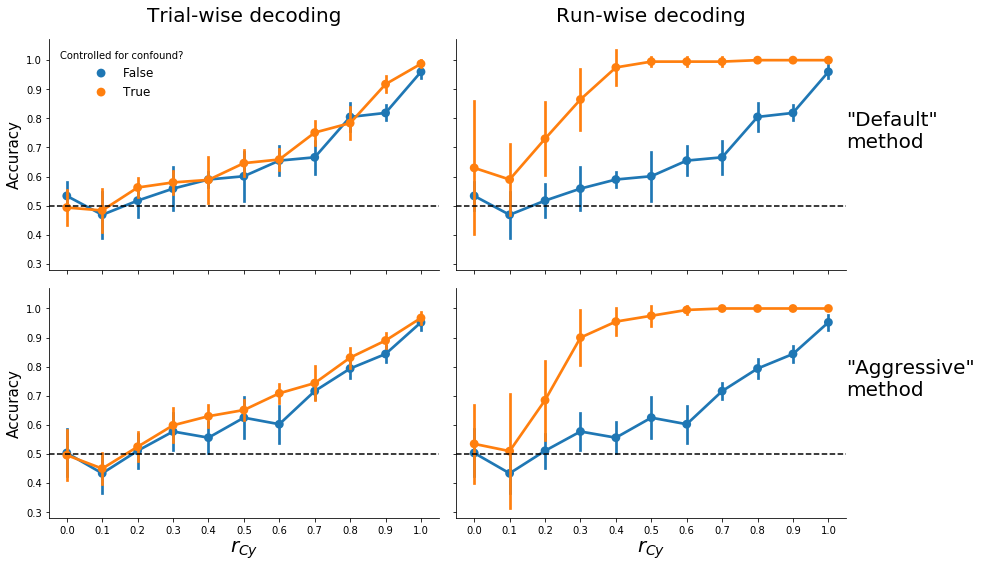

In [53]:
plt.figure(figsize=(11, 4))
txts = ['"Default"\nmethod', '"Default"\nmethod', '"Aggressive"\nmethod', '"Aggressive"\nmethod']
g = sns.factorplot(data=df_ccdpe, x='corr', y='acc', hue='controlled', col='analysis', row='aggressive',
                   aspect=1.5, legend_out=False, ci='sd')
for i, ax in enumerate(g.axes.flatten()):
    ax.axhline(0.5, ls='--', c='k')
    
    if i == 0:
        ax.set_title('Trial-wise decoding', fontsize=20, y=1.05)
        ax.legend(loc='upper left', title='Controlled for confound?', fontsize=12, frameon=False)
    elif i == 1:
        ax.set_title('Run-wise decoding', fontsize=20, y=1.05)
    else:
        ax.set_title('')
        
    if i in [0, 2]:
        ax.set_ylabel('Accuracy', fontsize=15)
    
    if i > 1:
        ax.set_xlabel('$r_{Cy}$', fontsize=20)

    if i in [1, 3]:
        ax.text(10.5, 0.7, txts[i], fontsize=20)
plt.tight_layout()

What is happening here? This method does not seem to work at all (we'd expect the blue line to center around 0.5). One of the reviewers anticipated this positive bias and suggested that it might have to with variance decoding: unequal variance in the features values across the two classes in the absence of any mean difference. We indeed find that this is the case, but only for the run-wise decoding analyses in combination with the "default" method. Anyway, let's check the the distributions of feature values (we'll use betas) in the trial-wise decoding analysis in combination with the default method (it also holds for the aggressive method; to see this, just set `aggressive=True`):

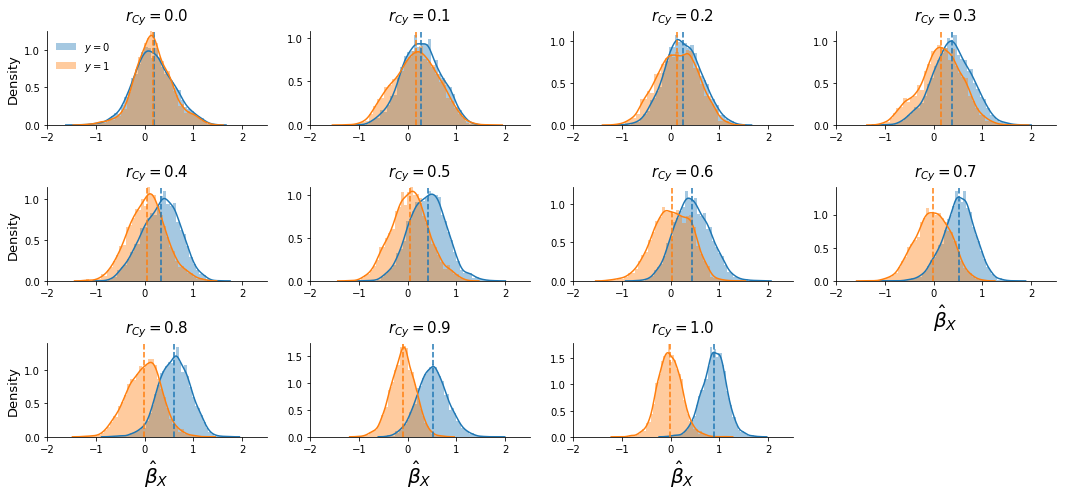

In [75]:
corrs = np.arange(0.0, 1.05, 0.1) # from 0 - 1 in steps of 0.1
pipe = make_pipeline(StandardScaler(), SVC(kernel='linear'))
plt.figure(figsize=(15, 7))
for i, corr in enumerate(corrs):

    fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                        K=(10, 10), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=True,
                        conf_params=dict(corr=corr, mean=1, std=0))

    #betas, sds, tvals, conds, group, conf = stack_runs(fmri_gen, R=10, control_for_conf=True, aggressive=True)
    #score = cross_val_score(pipe, tvals, target, groups=group, cv=10).mean()

    X, y, conds, true_params = fmri_gen.generate_data()
    betas, stderrs, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True, aggressive=False)
    score = cross_val_score(pipe, tvals, conds, cv=10).mean()
    plt.subplot(3, 4, i+1)
    sns.distplot(betas[conds == 0, :].ravel())
    sns.distplot(betas[conds == 1, :].ravel())

    if i == 0:
        plt.legend(['$y = 0$', '$y = 1$'], loc='upper left', frameon=False)
    
    plt.axvline(betas[conds == 0, :].mean(), ls='--', c='tab:blue')
    plt.axvline(betas[conds == 1, :].mean(), ls='--', c='tab:orange')
    plt.xlim(-2, 2.5)

    if i >= 7:
        ax = plt.gca()
        ax.set_xlabel(r'$\hat{\beta}_{X}$', fontsize=20)

    plt.title("$r_{Cy} = %.1f$" % corr, fontsize=15, y=1.05)

    if i in [0, 4, 8]:
        plt.ylabel('Density', fontsize=13)

sns.despine()
plt.tight_layout()
plt.show()

From the plot above it becomes clear that it's not variance decoding that is the problem, but that this method does seems to induce an *opposite* mean difference: before confound control, class 1 had a higher amplitude in the signal (as it reflects the true activation in response to that class + the confound) while after confound control, class 0 (blue density plots) has on average higher feature values! 

After a while, we figured out the reasons: the confound "absorbs" all of the variance related to class 0, forcing it's estimated beta-weights to zero (check the orange dashed lines in the plot above!), especially for higher correlation values. On the contrary, the estimated beta-weights for class 1 are recovered quite accurately, especially for high correlation values. This opposite effect of confound regression on class 0 and class 1, here, yields this change of the sign of the effect (class 0 < class 1 to class 0 > class 1).

Let's visualize this issue in more detail:

Mean beta, y = 0: 0.744
Mean beta, y = 1: -0.055


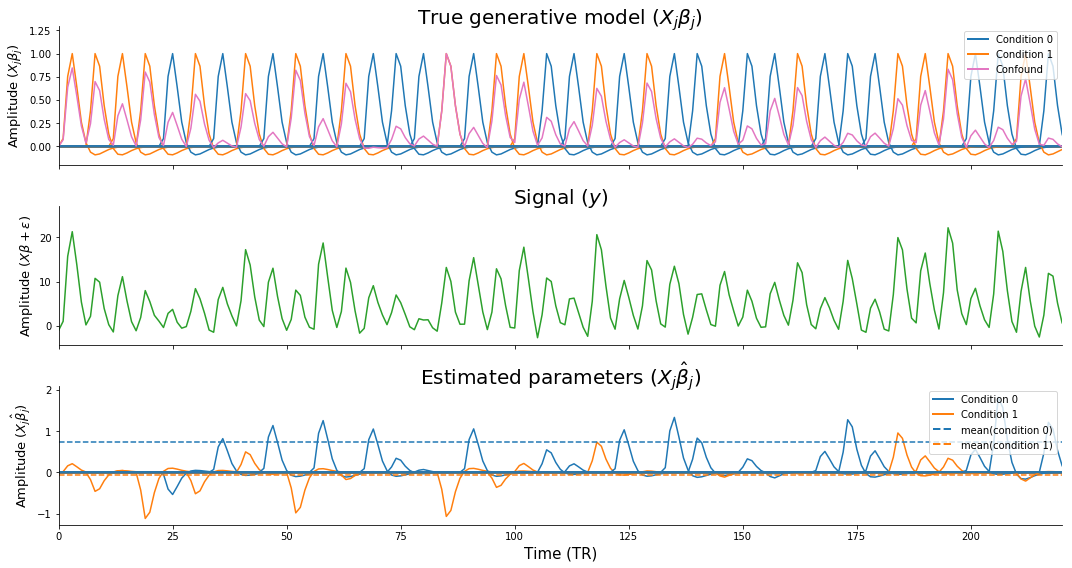

In [125]:
from matplotlib.lines import Line2D

fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[10], TR=2,
                        K=(2, 1), ar1_rho=0.5, smoothness=1,
                        noise_factor=1, cond_means=(1, 1),
                        cond_stds=(0.5, 0.5), single_trial=True,
                        conf_params=dict(corr=.9, mean=1, std=0))

X, y, conds, true_params = fmri_gen.generate_data()
betas, stderrs, tvals = fmri_gen.fit_glm(X, y, control_for_conf=True, aggressive=False)

fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(15, 8))
for i in np.arange(1, 81):
    ax[0].plot(X[:, i] / np.max(X[:, i]), c='tab:orange' if conds[i-1] else 'tab:blue')

ax[0].set_ylabel('Amplitude (%s)' % r'$X_{j}\beta_{j}$', fontsize=13)
ax[0].plot(X[:, -1] / np.max(X[:, -1]), c='tab:pink')

custom_lines = [Line2D([0], [0], color='tab:blue', lw=2),
                Line2D([0], [0], color='tab:orange', lw=2),
                Line2D([0], [0], color='tab:pink', lw=2)]

ax[0].legend(custom_lines, ['Condition 0', 'Condition 1', 'Confound'])
ax[0].set_ylim(-0.2, 1.3)
ax[0].set_title('True generative model (%s)' % r'$X_{j}\beta_{j}$', fontsize=20, y=0.97)

ax[1].plot(y[:, 0], c='tab:green')
ax[1].set_title("Signal (%s)" % '$y$', fontsize=20, y=0.97)
ax[1].set_ylabel("Amplitude (%s)" % r'$X\beta + \epsilon$', fontsize=13)

print("Mean beta, y = 0: %.3f" % betas[conds == 0, 0].mean())
print("Mean beta, y = 1: %.3f" % betas[conds == 1, 0].mean())

for i in np.arange(1, 81):
    ax[2].plot(X[:, i] / np.max(X[:, i]) * betas[i - 1, 0], c='tab:orange' if conds[i-1] else 'tab:blue')

#ax[2].plot(X[:, -1] / np.max(X[:, -1]) * betas[-1, 0], c='g')
ax[2].set_title('Estimated parameters (%s)' % r'$X_{j}\hat{\beta}_{j}$', fontsize=20, y=0.97)

custom_lines = [Line2D([0], [0], color='tab:blue', lw=2),
                Line2D([0], [0], color='tab:orange', lw=2),
                Line2D([0], [0], color='tab:blue', lw=2, ls='--'),
                Line2D([0], [0], color='tab:orange', lw=2, ls='--')]

ax[2].legend(custom_lines, ['Condition 0', 'Condition 1', 'mean(condition 0)', 'mean(condition 1)'],
                            loc='upper right')
ax[2].set_ylabel('Amplitude (%s)' % r'$X_{j}\hat{\beta}_{j}$', fontsize=13)

ax[2].axhline(betas[conds == 0, 0].mean(), ls='--', c='tab:blue')
ax[2].axhline(betas[conds == 1, 0].mean(), ls='--', c='tab:orange')
ax[2].set_xlabel('Time (TR)', fontsize=15)

for i in [0, 1, 2]:
    ax[i].set_xlim(0, 220)

    
sns.despine()
plt.tight_layout()

Alright, so this seems to be the problem! One could argue that this only happens when both conditions activate the voxel equally, and that this might not happen when both conditions *don't* activate the voxel. This is true, but in reality you would not know this! So better to err on the safe side, and don't use this.

That said, we promised to take a look at the run-wise decoding analyses with the "default" method, which do not *necessarily* lead to positive bias. In fact, this has to do with "variance decoding" (Hebart & Baker, 2017, NeuroImage).

In [171]:
results = dict(acc=[], corr=[], controlled=[], stat=[])
for i, corr in tqdm_notebook(enumerate(corrs), desc='corr'):
    
    iters = 10
    for ii in range(iters):

        fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                            K=(4, 4), ar1_rho=0.5, smoothness=1,
                            noise_factor=1, cond_means=(1, 1),
                            cond_stds=(0.5, 0.5), single_trial=False,
                            conf_params=dict(corr=corr, mean=1, std=0))
        
        betas, stderrs, tvals, target, group, conf = stack_runs(fmri_gen, R=10, control_for_conf=True)
        varz = stderrs**2
        acc = cross_val_score(pipe, betas, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(True)
        results['stat'].append('beta')
        
        acc = cross_val_score(pipe, varz, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(True)
        results['stat'].append('var')
        
        acc = cross_val_score(pipe, tvals, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(True)
        results['stat'].append('t-value')
        
        betas, stderrs, tvals, target, group, conf = stack_runs(fmri_gen, R=10, control_for_conf=False)
        varz = stderrs**2
        acc = cross_val_score(pipe, betas, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(False)
        results['stat'].append('beta')
        
        acc = cross_val_score(pipe, varz, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(False)
        results['stat'].append('var')
        
        acc = cross_val_score(pipe, tvals, target, groups=group, cv=10).mean()
        results['corr'].append(corr)
        results['acc'].append(acc)
        results['controlled'].append(False)
        results['stat'].append('t-value')
        
df_vardec = pd.DataFrame(results)
df_vardec['corr'] = df_vardec['corr'].round(1)

HBox(children=(IntProgress(value=1, bar_style='info', description='corr: ', max=1), HTML(value='')))

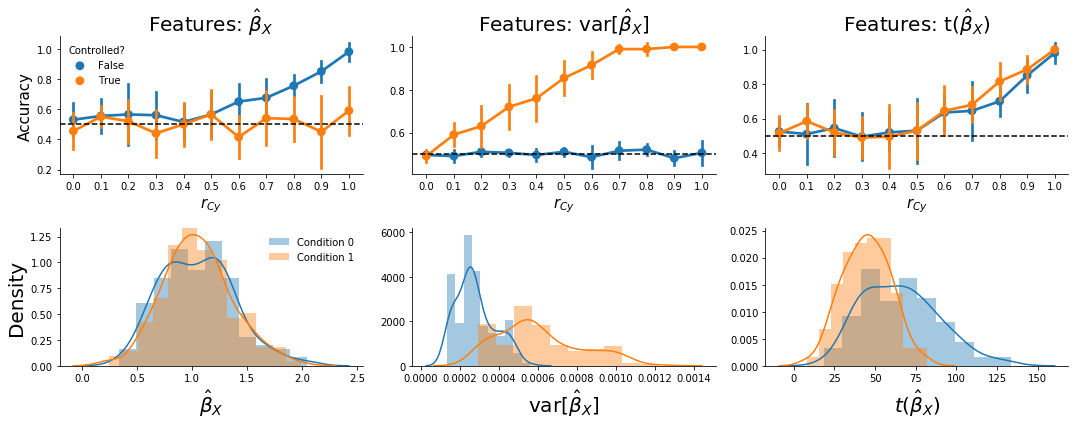

In [175]:
fig, ax = plt.subplots(nrows=2, ncols=3, sharex=False, figsize=(15, 6))
stat_names = ['Features: %s' % r'$\hat{\beta}_{X}$',
              'Features: var[%s]' % r'$\hat{\beta}_{X}$',
              'Features: t(%s)' % r'$\hat{\beta}_{X}$']

for i, stat in enumerate(['beta', 'var', 't-value']):
    this_df = df_vardec[df_vardec['stat'] == stat]
    sns.pointplot(data=this_df, x='corr', y='acc', hue='controlled', ax=ax[0, i], legend=False, ci='sd')
    ax[0, i].set_title(stat_names[i], fontsize=20)
    ax[0, i].axhline(0.5, ls='--', c='k')
    ax[0, i].set_xlabel(r'$r_{Cy}$', fontsize=15)
    
    if i == 0:
        ax[0, i].set_ylabel('Accuracy', fontsize=15)
        ax[0, i].legend(frameon=False, title='Controlled?')
    else:
        ax[0, i].set_ylabel('')
        ax[0, i].legend_.remove()

        
fmri_gen = FmriData(P=2, I=40, I_dur=1, ISIs=[4,5], TR=2,
                    K=(4, 4), ar1_rho=0.5, smoothness=1,
                    noise_factor=1, cond_means=(1, 1),
                    cond_stds=(0.5, 0.5), single_trial=False,
                    conf_params=dict(corr=0.8, mean=1, std=0))
betas, stderrs, tvals, target, group, conf = stack_runs(fmri_gen, R=10, control_for_conf=True)

sns.distplot(betas[conds == 0, :].ravel(), ax=ax[1, 0])
sns.distplot(betas[conds == 1, :].ravel(), ax=ax[1, 0])
ax[1, 0].legend(['Condition 0', 'Condition 1'], frameon=False)
ax[1, 0].set_xlabel(r'$\hat{\beta}_{X}$', fontsize=20)
ax[1, 0].set_ylabel('Density', fontsize=20)

varz = stderrs**2
sns.distplot(varz[conds == 0, :].ravel(), ax=ax[1, 1])
sns.distplot(varz[conds == 1, :].ravel(), ax=ax[1, 1])
ax[1, 1].set_xlabel(r'$\mathrm{var}[\hat{\beta}_{X}]$', fontsize=20)

sns.distplot(tvals[conds == 0, :].ravel(), ax=ax[1, 2])
sns.distplot(tvals[conds == 1, :].ravel(), ax=ax[1, 2])
ax[1, 2].set_xlabel(r'$t(\hat{\beta}_{X})$', fontsize=20)

sns.despine()
plt.tight_layout()
plt.show()